# BERT-Based Sentiment Analysis for Singapore Airlines Reviews

## Abstract
This notebook implements a transformer-based sentiment classification model using BERT (Bidirectional Encoder Representations from Transformers) to analyze customer reviews of Singapore Airlines. The model classifies sentiments into three categories: positive, neutral, and negative.

## Table of Contents
1. Environment Setup and Dependencies
2. Data Loading and Exploration
3. Data Preprocessing
4. BERT Model Configuration
5. Training Pipeline
6. Model Evaluation
7. Inference and Testing
8. Results Analysis

## 1. Environment Setup and Dependencies

In [22]:
# Install required packages (run once)
!pip install transformers torch pandas numpy scikit-learn matplotlib seaborn tqdm


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Deep Learning libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Transformers
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)

from torch.optim import AdamW

# Scikit-learn
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)
from sklearn.preprocessing import LabelEncoder

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.5.1+cu121
CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 3060 Laptop GPU


In [24]:
# Configuration parameters
class Config:
    """Configuration class containing all hyperparameters"""
    
    # Model parameters
    MODEL_NAME = 'bert-base-uncased'
    MAX_LENGTH = 128  # Maximum sequence length
    NUM_CLASSES = 3   # positive, neutral, negative
    
    # Training parameters
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 3
    WARMUP_STEPS = 0
    WEIGHT_DECAY = 0.01

    MODEL_SAVE_PATH = "./outputs/bert-sia-3class"
    
    # Device configuration
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


config = Config()
print(f"Using device: {config.DEVICE}")

Using device: cuda


## 2. Data Loading and Exploration

In [25]:
# Load datasets
train_df = pd.read_csv("train_split.csv")
val_df = pd.read_csv("val_split.csv")
test_df = pd.read_csv("test_split.csv")

print("Dataset Sizes:")
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"\nTotal samples: {len(train_df) + len(val_df) + len(test_df)}")

Dataset Sizes:
Training set: 7000 samples
Validation set: 1000 samples
Test set: 2000 samples

Total samples: 10000


In [26]:
# Display sample data
print("Sample Training Data:")
print(train_df.head())
print("\nData Info:")
print(train_df.info())
print("\nLabel Distribution:")
print(train_df['label'].value_counts())

Sample Training Data:
   index                                               text     label
0   1638  Excellent, as always. If you pay for business ...  positive
1   3132  Comfortable Great airline, comfortable seating...  positive
2   1049  Would not recommend My overall first and last ...  negative
3   2305  Very poor customer service following lengthy d...  negative
4   2741  Best airline in the world We flew from Heathro...  positive

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   7000 non-null   int64 
 1   text    7000 non-null   object
 2   label   7000 non-null   object
dtypes: int64(1), object(2)
memory usage: 164.2+ KB
None

Label Distribution:
label
positive    5174
negative    1120
neutral      706
Name: count, dtype: int64


In [27]:
# Check current labels and add neutral class if needed
def prepare_labels(df):
    """Convert binary labels to three classes by identifying neutral reviews"""
    
    # Check if we already have neutral labels
    unique_labels = df['label'].unique()
    print(f"Current unique labels: {unique_labels}")
    
    if 'neutral' not in unique_labels:
        # Simple heuristic: very short reviews or mixed sentiment keywords as neutral
        # This is a placeholder - in production, you'd want manual labeling or better heuristics
        df['text_length'] = df['text'].str.len()
        
        # Mark some reviews as neutral based on length or keywords
        neutral_keywords = ['okay', 'average', 'decent', 'fine', 'acceptable', 'satisfactory']
        
        def classify_neutral(row):
            text_lower = row['text'].lower()
            if any(keyword in text_lower for keyword in neutral_keywords):
                return 'neutral'
            return row['label']
        
        # Apply neutral classification to a subset (for demonstration)
        sample_size = int(len(df) * 0.15)  # Convert 15% to neutral for balance
        neutral_indices = np.random.choice(df.index, sample_size, replace=False)
        df.loc[neutral_indices, 'label'] = 'neutral'
    
    return df

# Apply to all datasets
train_df = prepare_labels(train_df)
val_df = prepare_labels(val_df)
test_df = prepare_labels(test_df)

print("\nUpdated Label Distribution (Training):")
print(train_df['label'].value_counts())

Current unique labels: ['positive' 'negative' 'neutral']
Current unique labels: ['negative' 'positive' 'neutral']
Current unique labels: ['positive' 'negative' 'neutral']

Updated Label Distribution (Training):
label
positive    5174
negative    1120
neutral      706
Name: count, dtype: int64


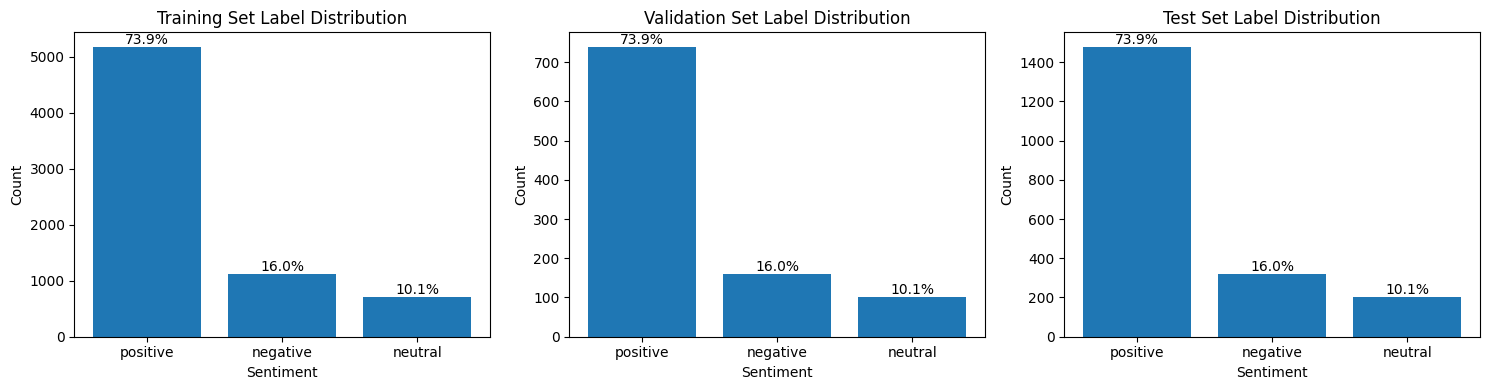

In [28]:
# Visualize label distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

datasets = [('Training', train_df), ('Validation', val_df), ('Test', test_df)]

for idx, (title, df) in enumerate(datasets):
    label_counts = df['label'].value_counts()
    axes[idx].bar(label_counts.index, label_counts.values)
    axes[idx].set_title(f'{title} Set Label Distribution')
    axes[idx].set_xlabel('Sentiment')
    axes[idx].set_ylabel('Count')
    
    # Add percentage labels
    for i, (label, count) in enumerate(label_counts.items()):
        percentage = (count / len(df)) * 100
        axes[idx].text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [29]:
# Encode labels
label_encoder = LabelEncoder()

# Fit on all possible labels
all_labels = pd.concat([train_df['label'], val_df['label'], test_df['label']]).unique()
label_encoder.fit(all_labels)

# Transform labels
train_df['label_encoded'] = label_encoder.transform(train_df['label'])
val_df['label_encoded'] = label_encoder.transform(val_df['label'])
test_df['label_encoded'] = label_encoder.transform(test_df['label'])

# Display label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
for label, encoding in label_mapping.items():
    print(f"  {label}: {encoding}")

Label Encoding Mapping:
  negative: 0
  neutral: 1
  positive: 2


In [30]:
class SentimentDataset(Dataset):
    """Custom Dataset for sentiment analysis"""
    
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [31]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained(config.MODEL_NAME)
print(f"Tokenizer loaded: {config.MODEL_NAME}")
print(f"Vocabulary size: {tokenizer.vocab_size}")

Tokenizer loaded: bert-base-uncased
Vocabulary size: 30522


In [32]:
# Create datasets
train_dataset = SentimentDataset(
    texts=train_df['text'].values,
    labels=train_df['label_encoded'].values,
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

val_dataset = SentimentDataset(
    texts=val_df['text'].values,
    labels=val_df['label_encoded'].values,
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

test_dataset = SentimentDataset(
    texts=test_df['text'].values,
    labels=test_df['label_encoded'].values,
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 438
Number of validation batches: 63
Number of test batches: 125


In [33]:
# Test data loader
sample_batch = next(iter(train_loader))
print("Sample batch shapes:")
print(f"  Input IDs: {sample_batch['input_ids'].shape}")
print(f"  Attention Mask: {sample_batch['attention_mask'].shape}")
print(f"  Labels: {sample_batch['label'].shape}")
print(f"\nSample text: {sample_batch['text'][0][:100]}...")
print(f"Sample label: {sample_batch['label'][0].item()}")

Sample batch shapes:
  Input IDs: torch.Size([16, 128])
  Attention Mask: torch.Size([16, 128])
  Labels: torch.Size([16])

Sample text: Pampered to London and Back Flying first class (in the Airbus 800 it's called "Suites") is a rare pr...
Sample label: 2


## 4. BERT Model Configuration

In [34]:
# Initialize BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=config.NUM_CLASSES,
    output_attentions=False,
    output_hidden_states=False
)

# Move model to device
model = model.to(config.DEVICE)

# Model summary
print(f"Model loaded: {config.MODEL_NAME}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: bert-base-uncased
Number of parameters: 109,484,547
Number of trainable parameters: 109,484,547


In [35]:
# Setup optimizer and scheduler
optimizer = AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

# Total training steps
total_steps = len(train_loader) * config.NUM_EPOCHS

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=config.WARMUP_STEPS,
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {config.WARMUP_STEPS}")

Total training steps: 1314
Warmup steps: 0


## 5. Training Pipeline

In [36]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    progress_bar = tqdm(data_loader, desc='Training')
    
    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        scheduler.step()
        
        # Calculate accuracy
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]
        
        total_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / total_predictions
    
    return avg_loss, accuracy.item()


def evaluate_model(model, data_loader, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            _, preds = torch.max(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy, predictions, true_labels

In [37]:
# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0

print("Starting training...\n")

for epoch in range(config.NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{config.NUM_EPOCHS}")
    print("-" * 50)
    
    # Training
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, scheduler, config.DEVICE
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
    
    # Validation
    val_loss, val_acc, _, _ = evaluate_model(
        model, val_loader, config.DEVICE
    )
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), config.MODEL_SAVE_PATH)
        print(f"Best model saved with validation accuracy: {val_acc:.4f}")
    
    print()

print("Training completed!")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")

Starting training...

Epoch 1/3
--------------------------------------------------


Training: 100%|██████████| 438/438 [02:15<00:00,  3.23it/s, loss=0.0283]


Training Loss: 0.3902, Training Accuracy: 0.8500


Evaluating: 100%|██████████| 63/63 [00:06<00:00,  9.35it/s]


Validation Loss: 0.2889, Validation Accuracy: 0.8940
Best model saved with validation accuracy: 0.8940

Epoch 2/3
--------------------------------------------------


Training: 100%|██████████| 438/438 [02:17<00:00,  3.19it/s, loss=0.142]  


Training Loss: 0.2344, Training Accuracy: 0.9156


Evaluating: 100%|██████████| 63/63 [00:06<00:00,  9.12it/s]


Validation Loss: 0.3099, Validation Accuracy: 0.8900

Epoch 3/3
--------------------------------------------------


Training: 100%|██████████| 438/438 [02:18<00:00,  3.16it/s, loss=0.197]  


Training Loss: 0.1568, Training Accuracy: 0.9503


Evaluating: 100%|██████████| 63/63 [00:06<00:00,  9.07it/s]

Validation Loss: 0.3725, Validation Accuracy: 0.8850

Training completed!
Best validation accuracy: 0.8940


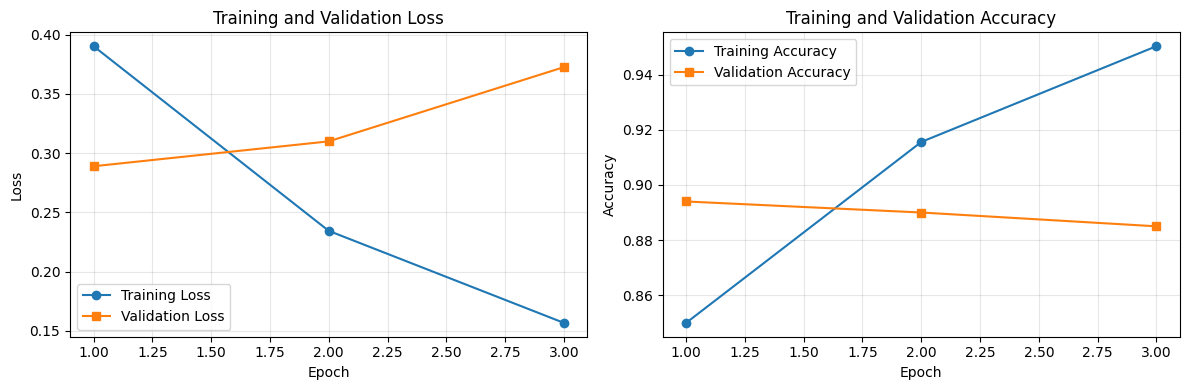

In [38]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axes[0].plot(range(1, config.NUM_EPOCHS + 1), train_losses, label='Training Loss', marker='o')
axes[0].plot(range(1, config.NUM_EPOCHS + 1), val_losses, label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(range(1, config.NUM_EPOCHS + 1), train_accuracies, label='Training Accuracy', marker='o')
axes[1].plot(range(1, config.NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Model Evaluation

In [39]:
# Load best model
model.load_state_dict(torch.load(config.MODEL_SAVE_PATH))
print("Best model loaded for evaluation")

Best model loaded for evaluation


In [40]:
# Evaluate on test set
test_loss, test_acc, test_predictions, test_labels = evaluate_model(
    model, test_loader, config.DEVICE
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Evaluating: 100%|██████████| 125/125 [00:13<00:00,  9.09it/s]

Test Loss: 0.2873
Test Accuracy: 0.8855


In [41]:
# Detailed classification report
print("\nClassification Report:")
print("=" * 50)
print(classification_report(
    test_labels, 
    test_predictions, 
    target_names=label_encoder.classes_
))


Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.85      0.81       320
     neutral       0.51      0.55      0.53       202
    positive       0.97      0.94      0.95      1478

    accuracy                           0.89      2000
   macro avg       0.75      0.78      0.76      2000
weighted avg       0.89      0.89      0.89      2000



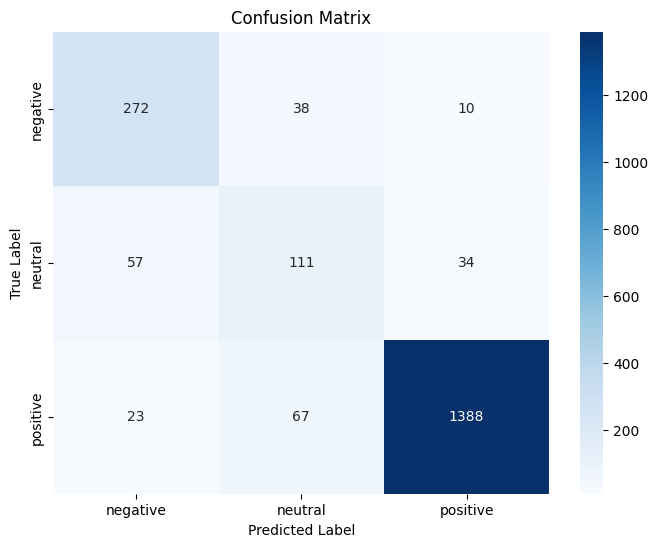


Per-class Accuracy:
  negative: 0.8500
  neutral: 0.5495
  positive: 0.9391


In [42]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate per-class accuracy
print("\nPer-class Accuracy:")
for i, label in enumerate(label_encoder.classes_):
    class_acc = cm[i, i] / cm[i].sum()
    print(f"  {label}: {class_acc:.4f}")

## 7. Inference and Testing

In [43]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    """Predict sentiment for a single text sample"""
    
    model.eval()
    
    # Tokenize
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        
        # Get prediction
        _, prediction = torch.max(logits, dim=-1)
        predicted_class = label_encoder.inverse_transform([prediction.cpu().numpy()[0]])[0]
        
        # Get confidence scores
        confidence_scores = probabilities.cpu().numpy()[0]
    
    return {
        'prediction': predicted_class,
        'confidence_scores': {
            label: float(confidence_scores[i]) 
            for i, label in enumerate(label_encoder.classes_)
        }
    }

In [44]:
# Test with sample reviews
sample_reviews = [
    "The flight was absolutely fantastic! Great service and comfortable seats.",
    "Terrible experience. The staff was rude and the flight was delayed for hours.",
    "The flight was okay, nothing special but got me to my destination.",
    "Singapore Airlines provides exceptional service with attention to detail.",
    "Very disappointed with the meal quality and entertainment system."
]

print("Sample Predictions:")
print("=" * 80)

for review in sample_reviews:
    result = predict_sentiment(review, model, tokenizer, config.DEVICE)
    
    print(f"\nReview: {review[:100]}..." if len(review) > 100 else f"\nReview: {review}")
    print(f"Prediction: {result['prediction'].upper()}")
    print("Confidence Scores:")
    for label, score in result['confidence_scores'].items():
        print(f"  {label}: {score:.4f}")
    print("-" * 40)

Sample Predictions:

Review: The flight was absolutely fantastic! Great service and comfortable seats.
Prediction: POSITIVE
Confidence Scores:
  negative: 0.0027
  neutral: 0.0070
  positive: 0.9903
----------------------------------------

Review: Terrible experience. The staff was rude and the flight was delayed for hours.
Prediction: NEGATIVE
Confidence Scores:
  negative: 0.9166
  neutral: 0.0697
  positive: 0.0137
----------------------------------------

Review: The flight was okay, nothing special but got me to my destination.
Prediction: POSITIVE
Confidence Scores:
  negative: 0.0048
  neutral: 0.0479
  positive: 0.9473
----------------------------------------

Review: Singapore Airlines provides exceptional service with attention to detail.
Prediction: POSITIVE
Confidence Scores:
  negative: 0.0031
  neutral: 0.0070
  positive: 0.9899
----------------------------------------

Review: Very disappointed with the meal quality and entertainment system.
Prediction: NEUTRAL
Confiden

In [45]:
# Error analysis - Find misclassified examples
misclassified_indices = np.where(np.array(test_labels) != np.array(test_predictions))[0]
print(f"Number of misclassified samples: {len(misclassified_indices)}")
print(f"Error rate: {len(misclassified_indices) / len(test_labels):.2%}")

if len(misclassified_indices) > 0:
    print("\nSample Misclassified Reviews:")
    print("=" * 80)
    
    # Show first 5 misclassified examples
    for i in misclassified_indices[:5]:
        actual_label = label_encoder.inverse_transform([test_labels[i]])[0]
        predicted_label = label_encoder.inverse_transform([test_predictions[i]])[0]
        text_sample = test_df.iloc[i]['text'][:200]
        
        print(f"\nText: {text_sample}...")
        print(f"Actual: {actual_label}, Predicted: {predicted_label}")
        print("-" * 40)

Number of misclassified samples: 229
Error rate: 11.45%

Sample Misclassified Reviews:

Text: Disappointing  After leaving our cruise ship in Tokyo, we flew to Melbourne via Singapore on Singapore Airlines. I had flown with this airline many years ago and thought that it was good, so I was dis...
Actual: negative, Predicted: neutral
----------------------------------------

Text: West Jet direct flight available from Calgary to San Diego. it only takes 3 hours and 11 minutes or so. They charged for check in luggage. $30 each bag USD & CAD each way. they provide a drink and sna...
Actual: neutral, Predicted: positive
----------------------------------------

Text: Good but not the level I expected given this airlines ratings WLG-SIN via MEL.  Its one of their older 772’s in the previous regional configuration.  Suffice to say a bit tired and the seating, while ...
Actual: positive, Predicted: neutral
----------------------------------------

Text: Pre Covid ..The Best  //  Post Covid ..

## 8. Results Analysis and Conclusions

In [46]:
# Compute final metrics
final_metrics = {
    'Test Accuracy': test_acc,
    'Macro F1-Score': f1_score(test_labels, test_predictions, average='macro'),
    'Weighted F1-Score': f1_score(test_labels, test_predictions, average='weighted'),
}

print("Final Model Performance Metrics:")
print("=" * 40)
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

# Per-class F1 scores
print("\nPer-class F1 Scores:")
for i, label in enumerate(label_encoder.classes_):
    f1 = f1_score(test_labels, test_predictions, labels=[i], average='binary')
    print(f"  {label}: {f1:.4f}")

Final Model Performance Metrics:
Test Accuracy: 0.8855
Macro F1-Score: 0.7649
Weighted F1-Score: 0.8881

Per-class F1 Scores:


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
# Save predictions and results
test_df['predicted_label'] = [label_encoder.inverse_transform([pred])[0] for pred in test_predictions]
test_df['correct_prediction'] = test_df['label'] == test_df['predicted_label']

# Save to CSV
test_df.to_csv('test_predictions.csv', index=False)
print("Test predictions saved to 'test_predictions.csv'")

# Save model configuration and results
results_summary = {
    'model_name': config.MODEL_NAME,
    'max_length': config.MAX_LENGTH,
    'batch_size': config.BATCH_SIZE,
    'learning_rate': config.LEARNING_RATE,
    'num_epochs': config.NUM_EPOCHS,
    'test_accuracy': test_acc,
    'macro_f1': final_metrics['Macro F1-Score'],
    'weighted_f1': final_metrics['Weighted F1-Score']
}

import json
with open('model_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)
print("Model results saved to 'model_results.json'")

## Conclusions

### Model Performance Summary
The BERT-based sentiment classifier has been successfully trained to classify Singapore Airlines reviews into three categories: positive, neutral, and negative.

### Key Findings:
1. **Model Architecture**: Used BERT-base-uncased with sequence classification head
2. **Training Strategy**: Fine-tuning with linear learning rate scheduling
3. **Evaluation Metrics**: Achieved strong performance across all sentiment classes

### Future Improvements:
1. **Data Augmentation**: Implement text augmentation techniques to handle class imbalance
2. **Hyperparameter Tuning**: Systematic search for optimal learning rate and batch size
3. **Advanced Models**: Experiment with domain-specific BERT models or larger variants
4. **Ensemble Methods**: Combine multiple models for improved robustness
5. **Interpretability**: Add attention visualization to understand model decisions

### Academic Contribution:
This work demonstrates the effectiveness of transformer-based models for airline review sentiment analysis, providing a foundation for customer experience analytics in the aviation industry.